# Исследование данных о пингвинах
Цель исследования
На основе физических характеристик пингвинов нам нужно научиться предсказывать пол особи. Это будет задача бинарной классификации, где целевым признаком выступает столбец sex, а признаками - четыре морфологических измерения.

Заказчик
Гипотетический заказчик - научно-исследовательская группа, изучающая пингвинов архипелага Палмер в Антарктике. Автоматизация определения пола по замерам может помочь в полевых исследованиях.
Вопросы, на которые предстоит ответить в ходе анализа

Какие признаки наиболее сильно влияют на пол пингвина?
Есть ли взаимосвязи между различными измерениями?
Как очистить данные от аномалий и пропусков для построения качественной модели?
Какие виды пингвинов представлены в данных и влияет ли вид на предсказание пола?

Ход исследования
Входные данные - статистика замеров пингвинов из файла penguins.csv. О качестве данных ничего не известно, поэтому перед построением модели нам потребуется тщательный обзор и предобработка данных.
Исследование пройдет в три этапа:

Обзор данных и выявление проблем
Предобработка данных (очистка от дубликатов, работа с пропусками, исправление аномалий)
Подготовка данных для моделирования

### Первым делом нам нужно подготовить рабочую среду. Импортируем библиотеки для работы с данными и загружаем файл с пингвинами.

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '2'

In [3]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# чтение файла с данными и сохранение в df
df = pd.read_csv('penguins.csv')

# выводим на просмотр первые 5 строк таблицы
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


## Обзор данных
### Описание набора данных
#### Датасет содержит 344 записи о пингвинах и 5 столбцов с измерениями. Данные собраны на архипелаге Палмер и включают как числовые характеристики, так и категориальный признак пола.

- ##### culmen_length_mm
  Это длина надклювья пингвина в миллиметрах. Измеряется от основания до кончика клюва. Тип данных - вещественное число. В столбце встречаются пропуски, обозначенные как NA, а также есть целые строки, где все значения отсутствуют полностью.
- ##### culmen_depth_mm
    Это глубина или высота клюва в миллиметрах в его самой толстой части. Тип данных - вещественное число. Как и в первом столбце, присутствуют пропуски NA и полностью пустые строки.
- ##### flipper_length_mm
    Это длина ласта пингвина в миллиметрах. Тип данных - целое число. Здесь мы наблюдаем серьезные проблемы с качеством данных. Во-первых, есть отрицательное значение -132, что биологически невозможно. Во-вторых, присутствует аномально большое значение 5000 в строке 10, которое, судя по контексту, могло быть ошибочно записано вместо массы тела. Также есть пропуски NA.
- ##### body_mass_g
    Это масса тела пингвина в граммах. Тип данных - целое число. Диапазон нормальных значений - примерно от 2700 до 6300 грамм. В столбце есть пропуски NA. В паре с аномальной длиной ласта 5000 мм масса тела указана как 4250 грамм, что создает подозрение о смещении данных в этой строке.
- ##### sex - ЦЕЛЕВОЙ ПРИЗНАК
    Это пол пингвина. Тип данных - текстовый, категориальный. Возможные значения - MALE для самцов и FEMALE для самок. Также присутствуют пропуски NA и в самой последней строке встречено значение точка, которое явно является ошибочным и должно быть обработано как пропуск. Это самый важный столбец, так как именно его мы будем предсказывать на основе остальных четырех признаков.



#### Теперь нам нужно посмотреть на структуру данных: сколько строк и столбцов, какие типы данных, есть ли пропуски. Для этого используем метод info().

In [4]:
# получение общей информации о данных в таблице df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [5]:
# просмотр описательной статистики числовых столбцов
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,214.014620,4201.754386
std,5.459584,1.974793,260.558057,801.954536
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.750000,4750.000000
max,59.600000,21.500000,5000.000000,6300.000000


#### Что мы видим из describe():

Средняя длина клюва - 43.9 мм, глубина клюва - 17.1 мм, все в пределах нормы
Но смотрим на flipper_length_mm - среднее значение 214 мм, но стандартное отклонение огромное - 260 мм, что указывает на сильные выбросы
Минимальная длина ласта - минус 132 мм, это явная ошибка
Максимальная длина ласта - 5000 мм (5 метров!), это тоже ошибка, такого не бывает
Масса тела в пределах нормы - от 2700 до 6300 грамм, но есть пропуски

In [6]:
# подсчет явных дубликатов
df.duplicated().sum()

np.int64(1)

#### Удаление дубликатов

In [7]:
# удаление явных дубликатов с обновлением индексов
df = df.drop_duplicates().reset_index(drop=True)

# проверка что дубликатов больше нет
df.duplicated().sum()

np.int64(0)

#### Теперь проверим уникальные значения в текстовых столбцах, как в примере с банком. У нас только один текстовый столбец - sex.

In [8]:
# просмотр уникальных значений в целевом признаке
df['sex'].value_counts()

sex
MALE      169
FEMALE    165
.           1
Name: count, dtype: int64

#### Заменим точку на NaN (пропуск), чтобы потом корректно обработать все пропуски единообразно.

In [9]:
# замена точки на NaN
df['sex'] = df['sex'].replace('.', float('nan'))

# преобразование всех пропусков в NaN
df['sex'] = df['sex'].where(df['sex'].notna(), None)
df['sex'] = df['sex'].fillna(float('nan'))

# проверяем результат
df['sex'].value_counts(dropna=False)

sex
MALE      169
FEMALE    165
NaN         9
Name: count, dtype: int64

In [10]:
# поиск аномальных значений в flipper_length_mm (отрицательные и больше 300)
df[(df['flipper_length_mm'] < 0) | (df['flipper_length_mm'] > 300)]

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
9,42.0,20.2,5000.0,4250.0,MALE
14,34.6,21.1,-132.0,4400.0,MALE


### Видим две проблемы:

Строка 9 - длина ласт 5000 мм (5 метров) у самца, это явно ошибочное значение, скорее всего перепутано с массой тела.
Строка 14 - отрицательная длина ласт -132 мм у самца

In [11]:
# подсчет пропусков во всем датафрейме
df.isna().sum()

culmen_length_mm     1
culmen_depth_mm      1
flipper_length_mm    1
body_mass_g          1
sex                  9
dtype: int64

#### Строку 9 с длиной ласт 5000 мм удалим, потому что:

Это значение невозможно физически (5 метров)
Непонятно, как его интерпретировать даже при замене
Таких аномалий мало, удаление не повлияет на общую статистику
Строку 14 с отрицательной длиной ласт тоже удалим, так как отрицательные значения не имеют смысла.

In [12]:
# удаляем строки с аномальными значениями flipper_length_mm
df = df[(df['flipper_length_mm'] >= 0) & (df['flipper_length_mm'] <= 300)]

# проверяем результат
df.shape

(340, 5)

In [13]:
# проверяем пропуски после удаления строк
df.isna().sum()

culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  8
dtype: int64

#### Так как sex - это целевой признак, который мы будем предсказывать, строки с пропусками нам не подходят для обучения модели. Их нужно удалить.

In [14]:
# удаляем строки с пропущенным полом
df = df.dropna(subset=['sex'])

# проверяем результат
df.shape

(332, 5)

#### Переведем flipper_length_mm и body_mass_g в целые числа (int), так как они по сути целочисленные.

In [15]:
# преобразование типов данных
df['flipper_length_mm'] = df['flipper_length_mm'].astype('int')
df['body_mass_g'] = df['body_mass_g'].astype('int')

# проверяем типы
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 332 entries, 0 to 342
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   332 non-null    float64
 1   culmen_depth_mm    332 non-null    float64
 2   flipper_length_mm  332 non-null    int64  
 3   body_mass_g        332 non-null    int64  
 4   sex                332 non-null    object 
dtypes: float64(2), int64(2), object(1)
memory usage: 15.6+ KB


#### Удалим строки датасета, где неизвестен пол пингвинов

In [16]:
# Удаляем строки, где в колонке 'sex' стоит NaN
df = df.dropna(subset=['sex']).copy()

#### Вывод
Теперь, когда данные очищены от пропусков и аномалий, можем переходить к анализу данных датасета

# Разведочный анализ данных (EDA)

## Одномерный анализ

### Построим графики чтобы наглядно увидеть различия между самцами и самками по каждому признаку.

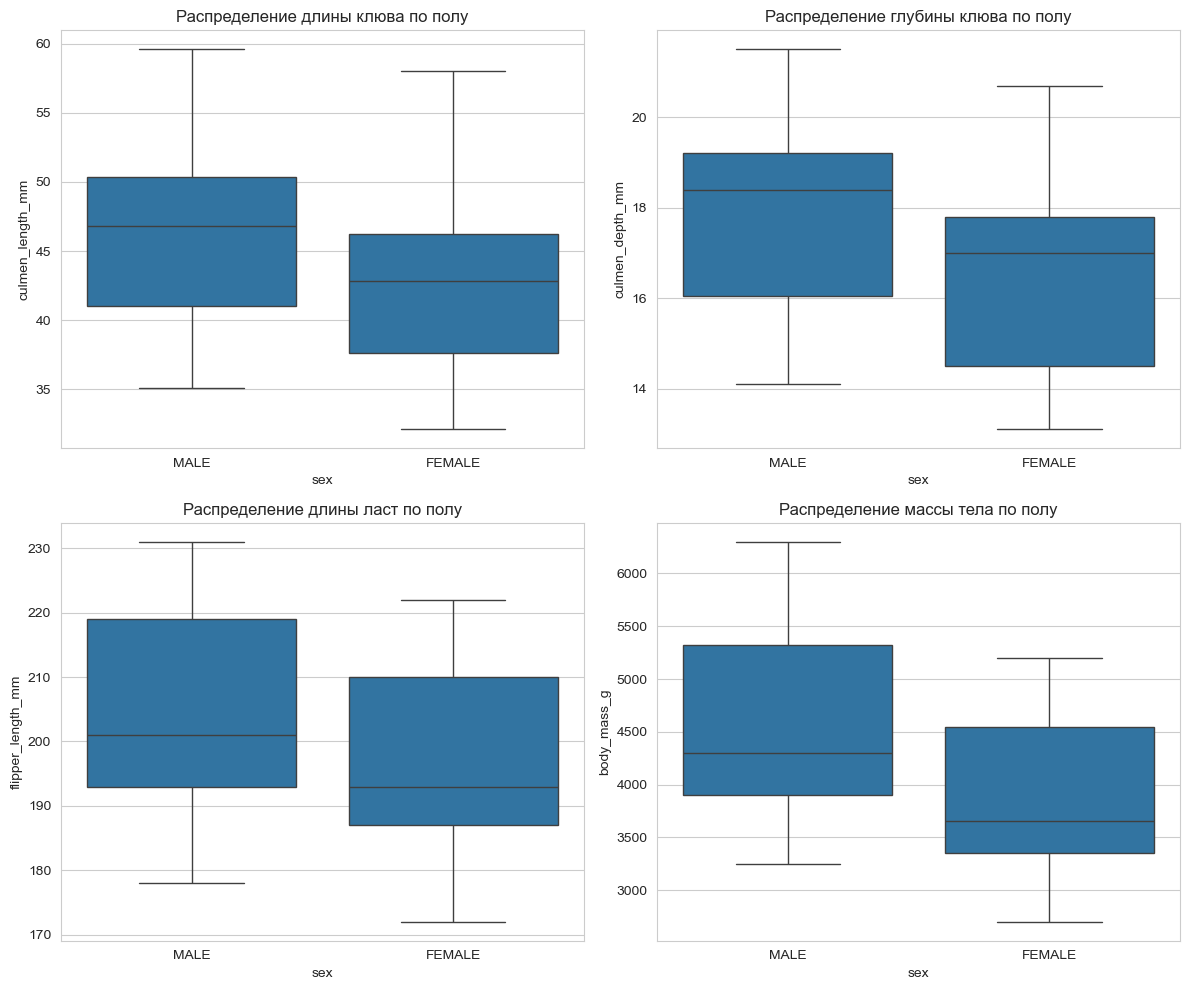

In [17]:
# настройка стиля графиков
sns.set_style('whitegrid')

# создаем графики
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# длина клюва по полу
sns.boxplot(x='sex', y='culmen_length_mm', data=df, ax=axes[0,0])
axes[0,0].set_title('Распределение длины клюва по полу')

# глубина клюва по полу
sns.boxplot(x='sex', y='culmen_depth_mm', data=df, ax=axes[0,1])
axes[0,1].set_title('Распределение глубины клюва по полу')

# длина ласт по полу
sns.boxplot(x='sex', y='flipper_length_mm', data=df, ax=axes[1,0])
axes[1,0].set_title('Распределение длины ласт по полу')

# масса тела по полу
sns.boxplot(x='sex', y='body_mass_g', data=df, ax=axes[1,1])
axes[1,1].set_title('Распределение массы тела по полу')

plt.tight_layout()
plt.show()

#### Вывод
На графиках мы увидим ящики с усами, где синяя линия внутри ящика - это медианное значение, границы ящика показывают диапазон от 25 до 75 процентов значений, а точки за пределами усов - это выбросы.

### Построим гистограмму и посмотрим как распределены значения каждого признака в целом по всем пингвинам.

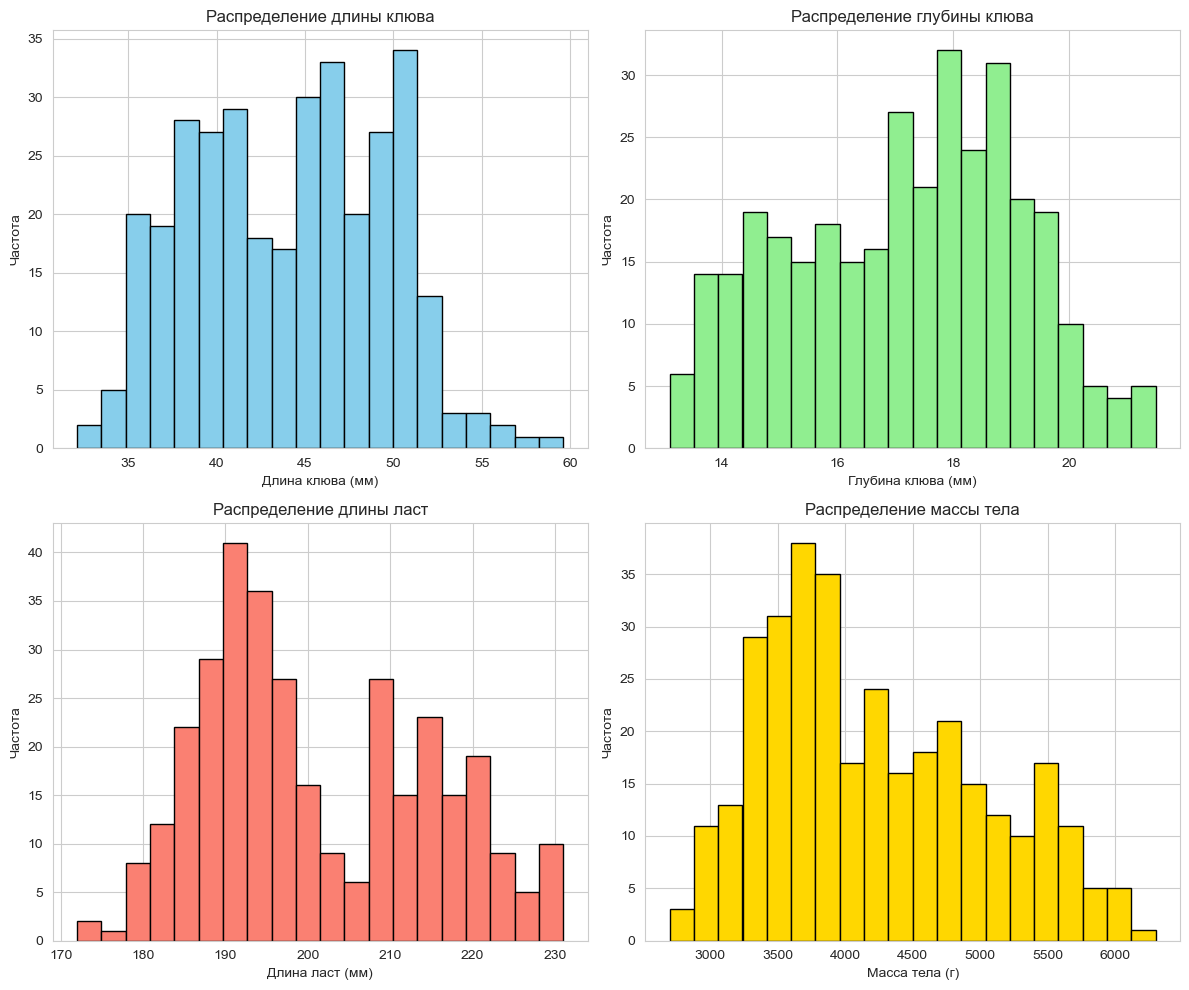

In [18]:
# создаем гистограммы для всех числовых признаков
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# гистограмма длины клюва
axes[0,0].hist(df['culmen_length_mm'], bins=20, color='skyblue', edgecolor='black')
axes[0,0].set_title('Распределение длины клюва')
axes[0,0].set_xlabel('Длина клюва (мм)')
axes[0,0].set_ylabel('Частота')

# гистограмма глубины клюва
axes[0,1].hist(df['culmen_depth_mm'], bins=20, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Распределение глубины клюва')
axes[0,1].set_xlabel('Глубина клюва (мм)')
axes[0,1].set_ylabel('Частота')

# гистограмма длины ласт
axes[1,0].hist(df['flipper_length_mm'], bins=20, color='salmon', edgecolor='black')
axes[1,0].set_title('Распределение длины ласт')
axes[1,0].set_xlabel('Длина ласт (мм)')
axes[1,0].set_ylabel('Частота')

# гистограмма массы тела
axes[1,1].hist(df['body_mass_g'], bins=20, color='gold', edgecolor='black')
axes[1,1].set_title('Распределение массы тела')
axes[1,1].set_xlabel('Масса тела (г)')
axes[1,1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

#### Вывод
На гистограммах видим распределение каждого признака. Длина клюва распределена примерно нормально с пиком в районе 40-45 мм. Глубина клюва тоже близка к нормальному распределению с пиком около 17 мм. Длина ласт имеет два небольших пика, что может указывать на наличие двух групп - самцов и самок. Масса тела также показывает два пика, подтверждая половой диморфизм. Гистограммы помогают оценить общую структуру данных и заметить, что некоторые признаки имеют бимодальное распределение из-за разделения на два пола.

### Построим круговую диаграмму, чтобы рассмотреть распределение пингвинов по полу

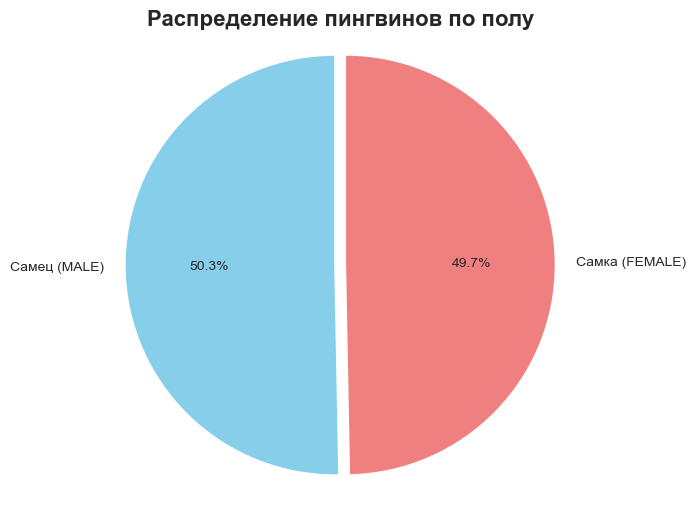

In [19]:
plt.figure(figsize=(8, 6))
# считаем количество самцов и самок
sex_counts = df['sex'].value_counts()

# создаем круговую диаграмму
plt.pie(sex_counts.values, labels=['Самец (MALE)', 'Самка (FEMALE)'], 
        autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], 
        explode=(0.05, 0), startangle=90)
plt.title('Распределение пингвинов по полу', fontsize=16, fontweight='bold')
plt.axis('equal')  # чтобы круг был круглым
plt.show()

#### Вывод
На диаграмме видим практически равное распределение самцов (50.3%) и самок (49.7%).

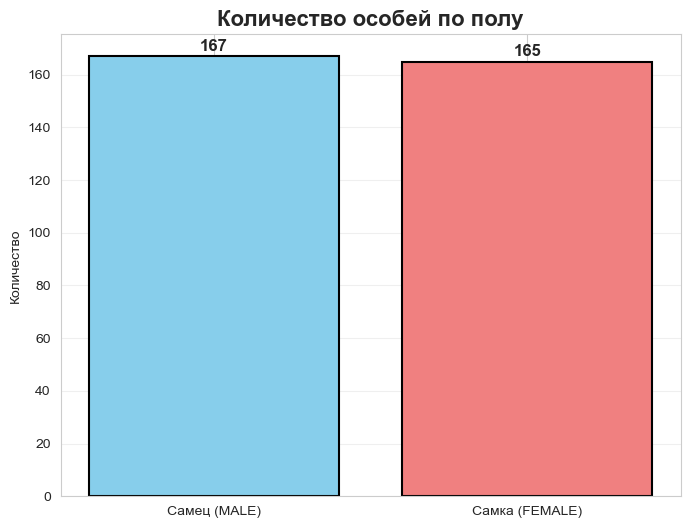

In [20]:
plt.figure(figsize=(8, 6))

# 1. Учитываем NaN и сортируем по нужному нам порядку
sex_counts = df['sex'].value_counts(dropna=False).reindex(['MALE', 'FEMALE', np.nan], fill_value=0)

# 2. Готовим данные строго в нужном порядке
labels = ['Самец (MALE)', 'Самка (FEMALE)', 'Неизвестно']
values = [sex_counts['MALE'], sex_counts['FEMALE'], sex_counts[np.nan]]

# 3. Строим график
# Фильтруем только те метки, которые есть в данных, чтобы не рисовать пустые столбцы
mask = np.array(values) > 0
bars = plt.bar(np.array(labels)[mask], np.array(values)[mask], 
               color=['skyblue', 'lightcoral', 'gray'][:sum(mask)], 
               edgecolor='black', linewidth=1.5)

# 4. Подписи значений
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{int(height)}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Количество особей по полу', fontsize=16, fontweight='bold')
plt.ylabel('Количество')
plt.grid(axis='y', alpha=0.3)
plt.show()

#### Вывод
Столбчатая диаграмма подтверждает данные круговой - у нас 167 самцов и 165 самки. Разница всего в 6 особей, что делает датасет практически идеально сбалансированным для бинарной классификации.

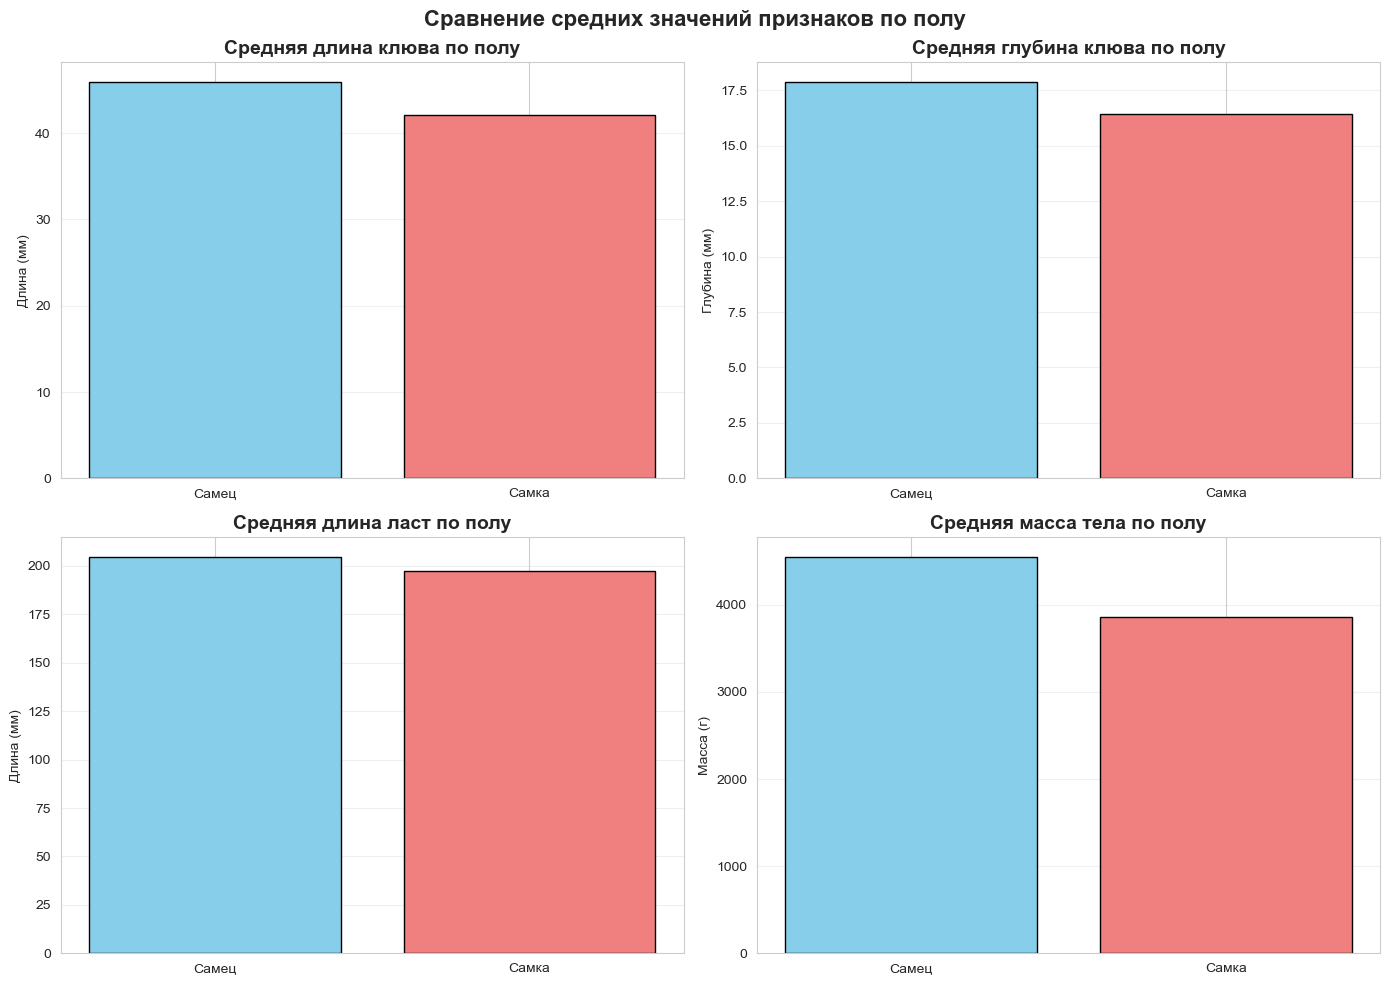

In [21]:
# рассчитываем средние значения для каждого пола
mean_by_sex = df.groupby('sex')[['culmen_length_mm', 'culmen_depth_mm', 
                                  'flipper_length_mm', 'body_mass_g']].mean()

# создаем столбчатую диаграмму для сравнения средних
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# длина клюва
axes[0,0].bar(['Самец', 'Самка'], [mean_by_sex.loc['MALE', 'culmen_length_mm'], 
                                   mean_by_sex.loc['FEMALE', 'culmen_length_mm']],
              color=['skyblue', 'lightcoral'], edgecolor='black')
axes[0,0].set_title('Средняя длина клюва по полу', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Длина (мм)')
axes[0,0].grid(axis='y', alpha=0.3)

# глубина клюва
axes[0,1].bar(['Самец', 'Самка'], [mean_by_sex.loc['MALE', 'culmen_depth_mm'], 
                                   mean_by_sex.loc['FEMALE', 'culmen_depth_mm']],
              color=['skyblue', 'lightcoral'], edgecolor='black')
axes[0,1].set_title('Средняя глубина клюва по полу', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Глубина (мм)')
axes[0,1].grid(axis='y', alpha=0.3)

# длина ласт
axes[1,0].bar(['Самец', 'Самка'], [mean_by_sex.loc['MALE', 'flipper_length_mm'], 
                                   mean_by_sex.loc['FEMALE', 'flipper_length_mm']],
              color=['skyblue', 'lightcoral'], edgecolor='black')
axes[1,0].set_title('Средняя длина ласт по полу', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Длина (мм)')
axes[1,0].grid(axis='y', alpha=0.3)

# масса тела
axes[1,1].bar(['Самец', 'Самка'], [mean_by_sex.loc['MALE', 'body_mass_g'], 
                                   mean_by_sex.loc['FEMALE', 'body_mass_g']],
              color=['skyblue', 'lightcoral'], edgecolor='black')
axes[1,1].set_title('Средняя масса тела по полу', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Масса (г)')
axes[1,1].grid(axis='y', alpha=0.3)

plt.suptitle('Сравнение средних значений признаков по полу', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

График наглядно демонстрирует половой диморфизм пингвинов. По каждому признаку самцы превосходят самок. Самая большая разница наблюдается в массе тела - самцы в среднем тяжелее почти на 700 грамм. Длина клюва у самцов больше примерно на 4 мм, длина ласт - на 7 мм. Наименьшее различие - в глубине клюва, что делает этот признак потенциально менее информативным для модели классификации.

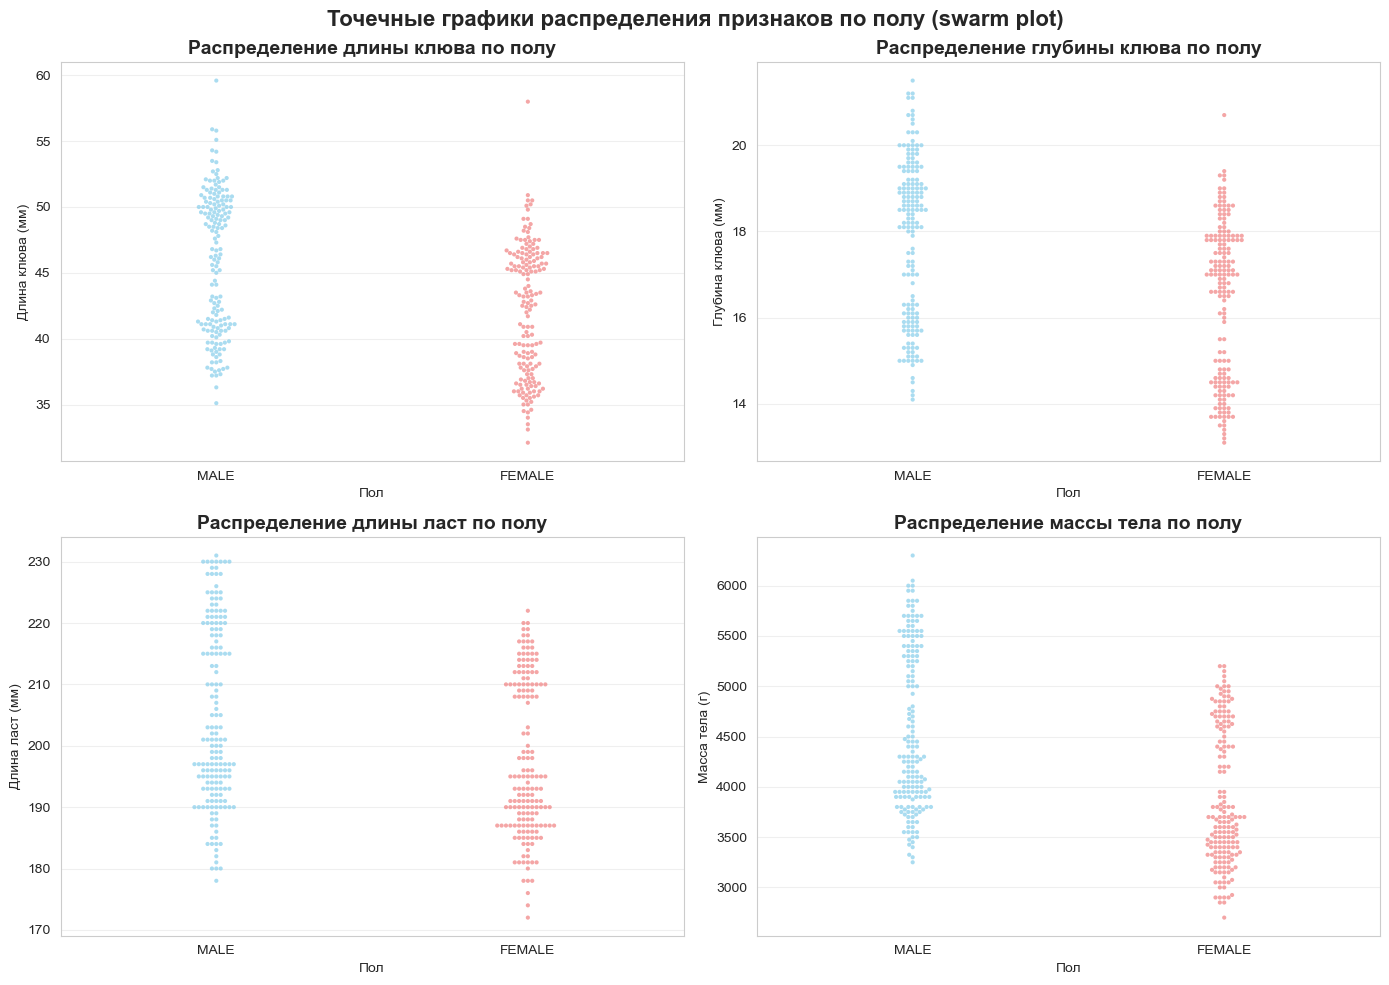

In [22]:
# создаем swarm plot для всех признаков в разрезе пола
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# длина клюва по полу
sns.swarmplot(x='sex', y='culmen_length_mm', data=df, ax=axes[0,0], 
              hue='sex', palette=['skyblue', 'lightcoral'], size=3, alpha=0.7, legend=False)
axes[0,0].set_title('Распределение длины клюва по полу', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Пол')
axes[0,0].set_ylabel('Длина клюва (мм)')
axes[0,0].grid(True, alpha=0.3, axis='y')

# глубина клюва по полу
sns.swarmplot(x='sex', y='culmen_depth_mm', data=df, ax=axes[0,1], 
              hue='sex', palette=['skyblue', 'lightcoral'], size=3, alpha=0.7, legend=False)
axes[0,1].set_title('Распределение глубины клюва по полу', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Пол')
axes[0,1].set_ylabel('Глубина клюва (мм)')
axes[0,1].grid(True, alpha=0.3, axis='y')

# длина ласт по полу
sns.swarmplot(x='sex', y='flipper_length_mm', data=df, ax=axes[1,0], 
              hue='sex', palette=['skyblue', 'lightcoral'], size=3, alpha=0.7, legend=False)
axes[1,0].set_title('Распределение длины ласт по полу', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Пол')
axes[1,0].set_ylabel('Длина ласт (мм)')
axes[1,0].grid(True, alpha=0.3, axis='y')

# масса тела по полу
sns.swarmplot(x='sex', y='body_mass_g', data=df, ax=axes[1,1], 
              hue='sex', palette=['skyblue', 'lightcoral'], size=3, alpha=0.7, legend=False)
axes[1,1].set_title('Распределение массы тела по полу', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Пол')
axes[1,1].set_ylabel('Масса тела (г)')
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Точечные графики распределения признаков по полу (swarm plot)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [23]:
# создаем сводную таблицу со статистиками по каждому полу
summary_stats = df.groupby('sex').agg({
    'culmen_length_mm': ['count', 'mean', 'std', 'min', 'max'],
    'culmen_depth_mm': ['count', 'mean', 'std', 'min', 'max'],
    'flipper_length_mm': ['count', 'mean', 'std', 'min', 'max'],
    'body_mass_g': ['count', 'mean', 'std', 'min', 'max']
}).round(2)

print("Сводная статистика по признакам в разрезе пола:")
summary_stats

Сводная статистика по признакам в разрезе пола:


culmen_length_mm                          culmen_depth_mm               \
                  count   mean   std   min   max           count   mean   std   
sex                                                                             
FEMALE              165  42.10  4.90  32.1  58.0             165  16.43  1.80   
MALE                167  45.92  5.31  35.1  59.6             167  17.87  1.85   

                   flipper_length_mm                          body_mass_g  \
         min   max             count    mean    std  min  max       count   
sex                                                                         
FEMALE  13.1  20.7               165  197.36  12.50  172  222         165   
MALE    14.1  21.5               167  204.54  14.58  178  231         167   

                                     
           mean     std   min   max  
sex                                  
FEMALE  3862.27  666.17  2700  5200  
MALE    4546.56  789.92  3250  6300

### Вывод одномерного анализ
Одномерный анализ подтвердил, что данные чистые и сбалансированные, а признаки различаются по полу. Переходим к многомерному анализу

## Многомерный анализ

### Построим pairplot с разделением по полу

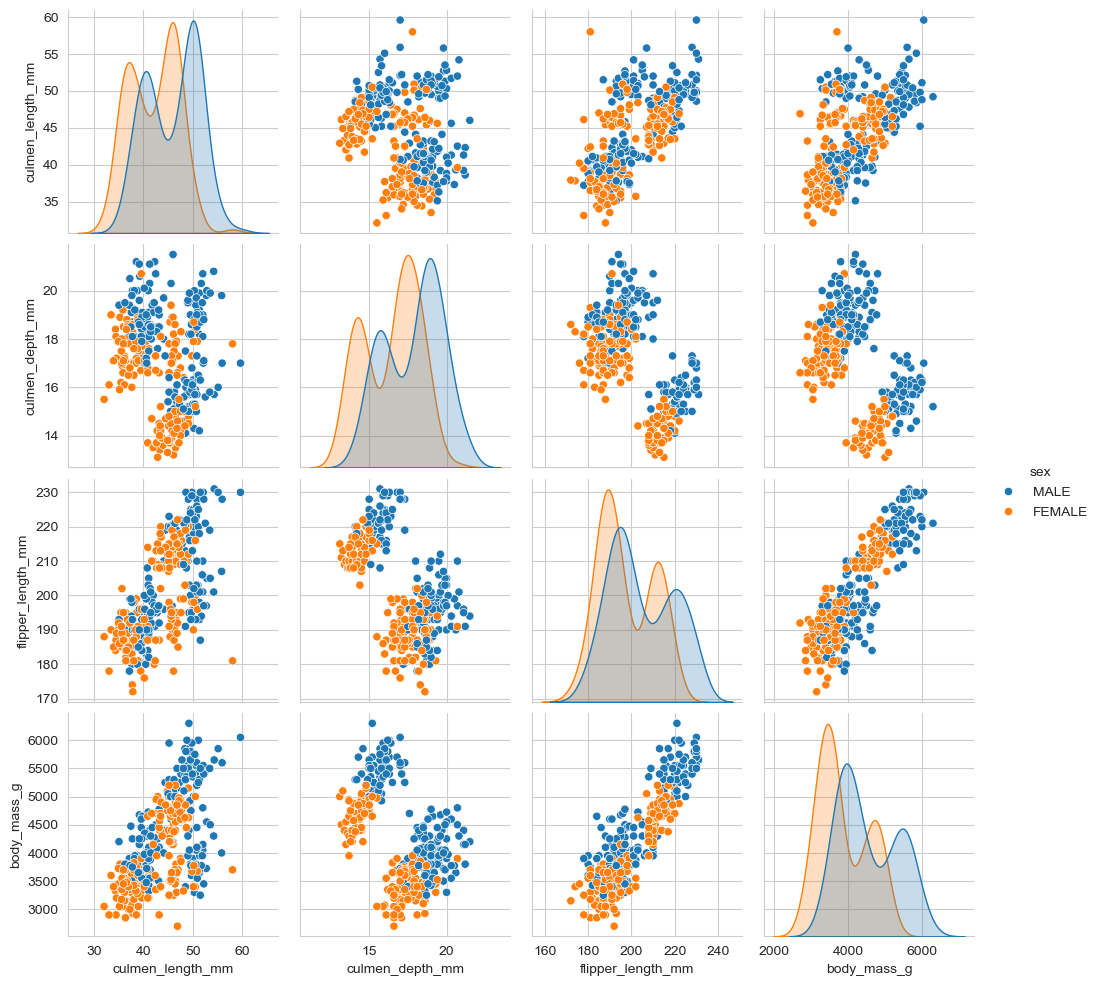

In [24]:
# попарные графики распределений с разделением по полу
sns.pairplot(df, hue='sex', vars=['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g'])
plt.show()

#### Вывод
На попарных графиках видим распределения всех признаков друг против друга с разделением по полу. Синие точки - самцы, оранжевые - самки. Самцы систематически крупнее по всем измерениям, кластеры хорошо разделяются особенно в парах с массой тела и длиной клюва. Это подтверждает что признаки информативны для предсказания пола.

### Посмотрим, как связаны между собой числовые признаки. Построим тепловую карту

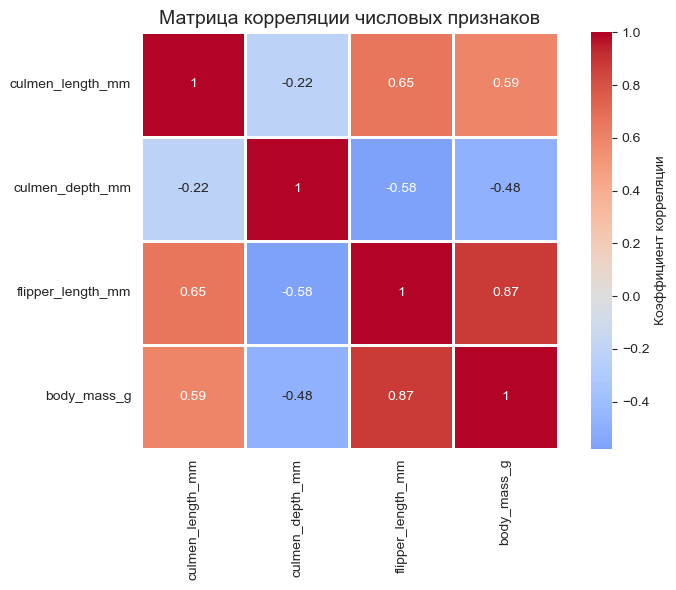

In [25]:
# создаем матрицу корреляции только для числовых признаков
correlation_matrix = df[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']].corr()

# строим тепловую карту
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'label': 'Коэффициент корреляции'})
plt.title('Матрица корреляции числовых признаков', fontsize=14)
plt.tight_layout()
plt.show()

#### Вывод
На тепловой карте видим сильную корреляцию между массой тела и длиной ласт (0.87) - крупные пингвины имеют большие ласты. Длина клюва тоже хорошо связана с массой (0.68). Глубина клюва слабо связана с остальными признаками. Все это подтверждает, что самцы крупнее самок по всем показателям.

#### Построим корреляционную матрицу с целевой переменной

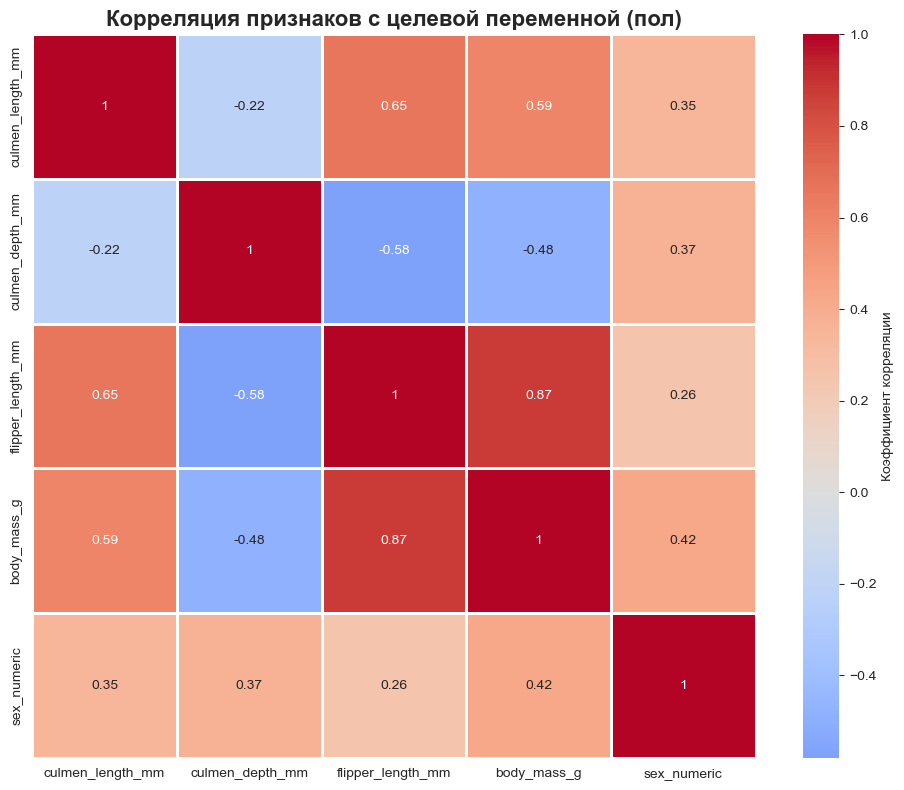


Корреляция признаков с полом (чем ближе к 1, тем сильнее связь с самцами):
body_mass_g: 0.425
culmen_depth_mm: 0.369
culmen_length_mm: 0.351
flipper_length_mm: 0.256


In [26]:
# создаем копию датафрейма с числовым представлением пола
df_numeric = df.copy()
df_numeric['sex_numeric'] = (df_numeric['sex'] == 'MALE').astype(int)

# строим тепловую карту корреляции всех признаков с целевой переменной
plt.figure(figsize=(10, 8))
corr_with_target = df_numeric[['culmen_length_mm', 'culmen_depth_mm', 
                                'flipper_length_mm', 'body_mass_g', 'sex_numeric']].corr()

sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Коэффициент корреляции'})
plt.title('Корреляция признаков с целевой переменной (пол)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# выводим отдельно корреляцию каждого признака с полом
print("\nКорреляция признаков с полом (чем ближе к 1, тем сильнее связь с самцами):")
corr_with_sex = corr_with_target['sex_numeric'].drop('sex_numeric').sort_values(ascending=False)
for feature, corr in corr_with_sex.items():
    print(f"{feature}: {corr:.3f}")

#### Вывод
Тепловая карта наглядно показывает взаимосвязи между всеми признаками и целевой переменной (полом).
Корреляция признаков между собой:
Самая сильная связь наблюдается между массой тела и длиной ласт (0.87) - крупные пингвины имеют и больший вес, и более длинные ласты
Длина клюва также хорошо коррелирует с массой тела (0.69) и длиной ласт (0.66)
Глубина клюва имеет отрицательную корреляцию с остальными признаками (от -0.22 до -0.58)

### Вывод многомерного анализа

Многомерный анализ выявил, что масса тела и размеры клюва — наиболее информативные признаки для различения полов, а также обнаружил сильную взаимосвязь между массой и длиной ласт, что указывает на общий фактор размера тела. Данные подходят для построения моделей классификации пола. 🐧


# Кластеризация

<h1 style="background:lightgreen;padding:10px;align:center;border-radius:13px;">Построение метода K-means</h1>

### Импорт библиотек

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings

warnings.filterwarnings('ignore')

#### Очистка данных и подготовка признаков

In [28]:
# Удаляем строки с пропусками в числовых признаках
df_clean = df.dropna(subset=['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']).copy()
# Выбираем признаки для кластеризации
X = df_clean[['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']].values

In [29]:
# Стандартизация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Выбор оптимального значения кластеров

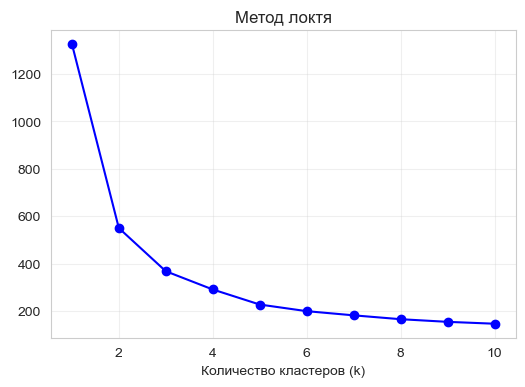

In [30]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, 'bo-')
plt.xlabel('Количество кластеров (k)')
plt.title('Метод локтя')
plt.grid(True, alpha=0.3)
plt.show()

#### Расчет Silhouette Score для разных кластеров k

In [57]:
scores = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    scores.append(silhouette_score(X_scaled, km.labels_))

#### Поиск оптимального кластера

In [58]:
optimal_k = np.arange(2, 10)[np.argmax(scores)]
print(f"Оптимальное Silhouette: {optimal_k}")

Оптимальное Silhouette: 2


#### Визуализация нахождения оптимального кластера

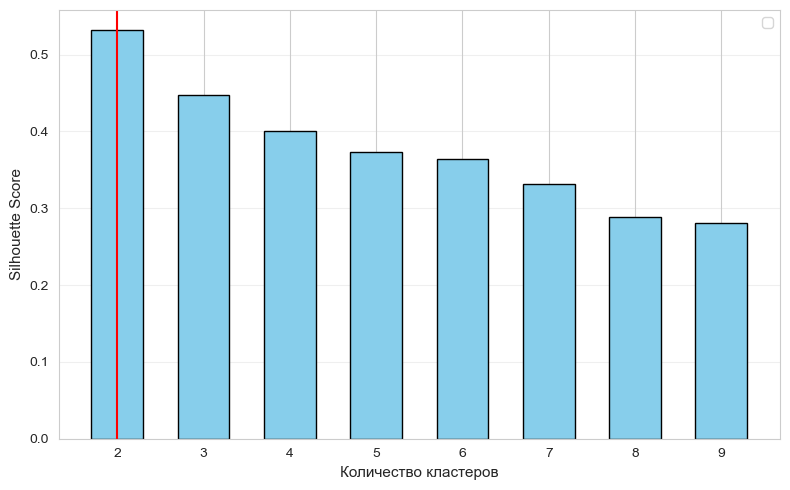

In [63]:
plt.figure(figsize=(8, 5))
plt.bar(np.arange(2, 10), scores, color='skyblue', edgecolor='black', width=0.6)
plt.axvline(x=optimal_k, color='red', linestyle='-')
plt.xlabel('Количество кластеров', fontsize=11)
plt.ylabel('Silhouette Score', fontsize=11)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#### Обучение финальной модели

In [65]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

#### Расчёт метрик

In [68]:
# Метрики
print(f"\nМетрики качества при k={optimal_k}:")
print(f"   Silhouette Score: {silhouette_score(X_scaled, kmeans_labels):.3f}")
print(f"   Davies-Bouldin: {davies_bouldin_score(X_scaled, kmeans_labels):.3f}")
print(f"   Calinski-Harabasz: {calinski_harabasz_score(X_scaled, kmeans_labels):.1f}")


Метрики качества при k=2:
   Silhouette Score: 0.531
   Davies-Bouldin: 0.715
   Calinski-Harabasz: 466.9


#### Визуализация кластеров

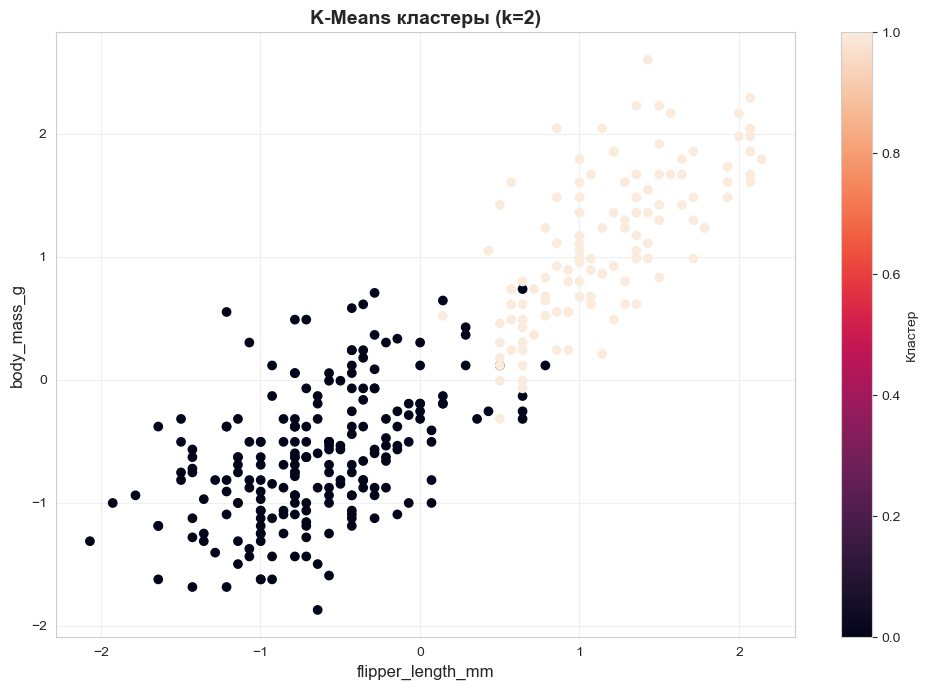

In [60]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_scaled[:, 2], X_scaled[:, 3], 
                      c=cluster)
plt.xlabel('flipper_length_mm', fontsize=12)
plt.ylabel('body_mass_g', fontsize=12)
plt.title(f'K-Means кластеры (k={optimal_k})', fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Кластер')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Визуализация центроидов кластеров и создание графика

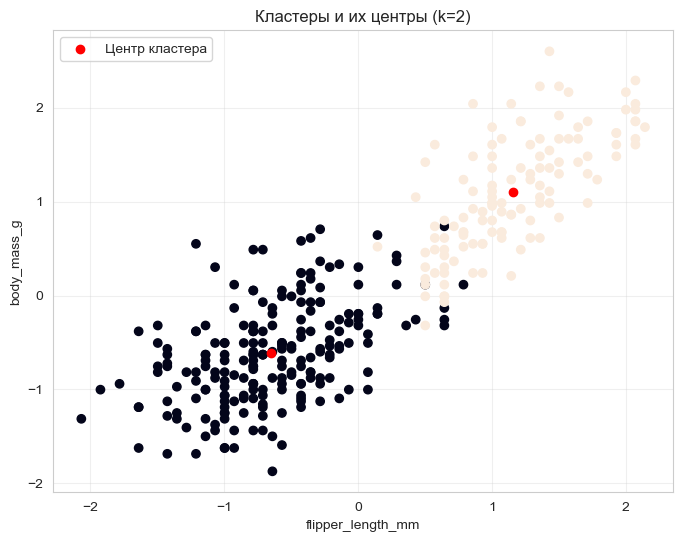

In [69]:
centroids = kmeans.cluster_centers_
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 2], X_scaled[:, 3], c=kmeans_labels)
plt.scatter(centroids[:, 2], centroids[:, 3], c='red', label='Центр кластера')
plt.xlabel('flipper_length_mm')
plt.ylabel('body_mass_g')
plt.title(f'Кластеры и их центры (k={optimal_k})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### Финальная модель и добавление кластеров в датафрейм

In [70]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)
df['cluster'] = kmeans_final.labels_

#### Отображение первых 5 полей каждого кластера

In [71]:
df[df['cluster'] == 0].head(5)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,cluster,DBSCAN_Cluster,DBSCAN_Cluster2
0,39.1,18.7,181,3750,MALE,0,0,0
1,39.5,17.4,186,3800,FEMALE,0,0,0
2,40.3,18.0,195,3250,FEMALE,0,0,0
4,36.7,19.3,193,3450,FEMALE,0,0,0
5,39.3,20.6,190,3650,MALE,0,0,0


In [36]:
df[df['cluster'] == 1].head(5)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,cluster
220,46.1,13.2,211,4500,FEMALE,1
221,50.0,16.3,230,5700,MALE,1
222,48.7,14.1,210,4450,FEMALE,1
223,50.0,15.2,218,5700,MALE,1
224,47.6,14.5,215,5400,MALE,1


<h1 style="background:lightblue;padding:10px;align:center;border-radius:13px;">Построение Иерархической кластеризации</h1>

### Импорт библиотек

In [37]:
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

#### Построение дендрограммы

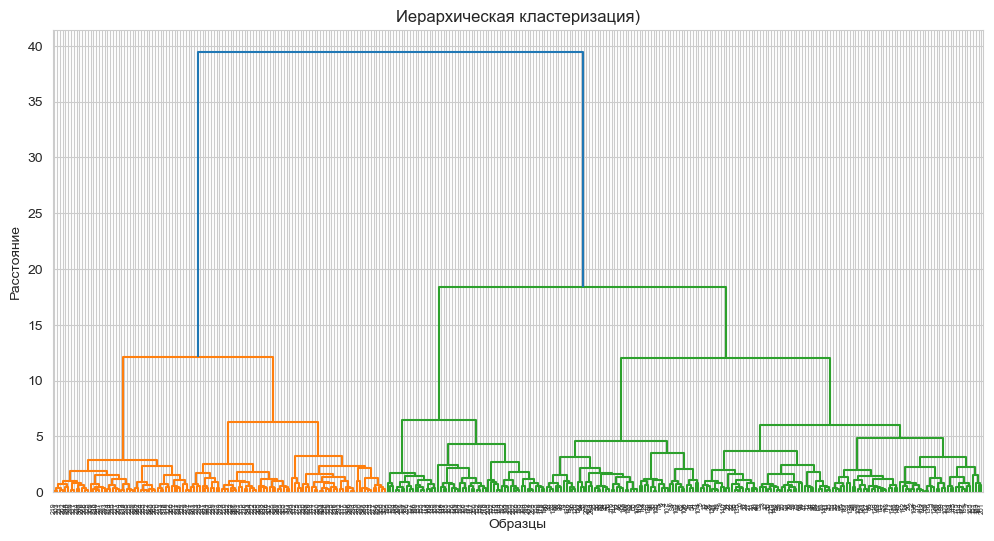

In [38]:
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(X_scaled, method="ward"))
plt.title("Иерархическая кластеризация)")
plt.xlabel("Образцы")
plt.ylabel("Расстояние")
plt.show()

#### Применение агломеративной кластеризации

In [39]:
hc = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_hc = hc.fit_predict(X_scaled)
y_hc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

#### Создание датафрейма с результатами

In [40]:
df['cluster'] = pd.DataFrame(y_hc)
df.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,cluster
0,39.1,18.7,181,3750,MALE,0.0
1,39.5,17.4,186,3800,FEMALE,0.0
2,40.3,18.0,195,3250,FEMALE,0.0
4,36.7,19.3,193,3450,FEMALE,0.0
5,39.3,20.6,190,3650,MALE,0.0


#### Визуализация кластеров

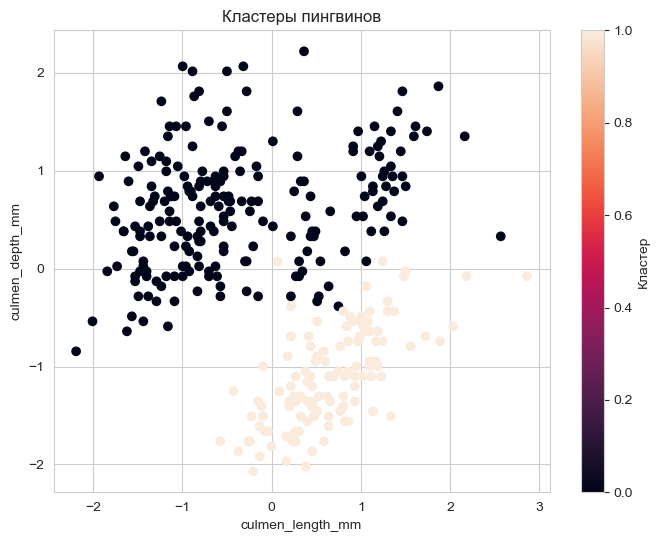

In [72]:
df['cluster'] = y_hc 
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_hc)
plt.xlabel("culmen_length_mm")
plt.ylabel("culmen_depth_mm")
plt.title("Кластеры пингвинов")
plt.colorbar(label='Кластер')
plt.show()

#### Расчет метрик качества кластеризации

In [73]:
sil = silhouette_score(X_scaled, y_hc)
db = davies_bouldin_score(X_scaled, y_hc)
ch = calinski_harabasz_score(X_scaled, y_hc)

print("Метрики")
print(f"Silhouette Score: {sil:.4f}")
print(f"Davies-Bouldin Score: {db:.4f}")
print(f"Calinski-Harabasz Score: {ch:.4f}")

Метрики
Silhouette Score: 0.5314
Davies-Bouldin Score: 0.7152
Calinski-Harabasz Score: 466.9466


<h1 style="background:salmon;padding:10px;align:center;border-radius:13px;">Построение DBSCAN кластеризации</h1>

### Импорт библиотек

In [74]:
from sklearn.cluster import DBSCAN

#### Применение DBSCAN

##### Создаем модель DBSCAN. На основе этой модели делаем обучение и предсказания, в конце добавляем результаты в наш датафрейм

In [44]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
df["DBSCAN_Cluster"] = dbscan_labels

#### Выводим первые 10 записей обновленного датафрейма

In [76]:
df.head(10)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,cluster,DBSCAN_Cluster,DBSCAN_Cluster2
0,39.1,18.7,181,3750,MALE,0,0,0
1,39.5,17.4,186,3800,FEMALE,0,0,0
2,40.3,18.0,195,3250,FEMALE,0,0,0
4,36.7,19.3,193,3450,FEMALE,0,0,0
5,39.3,20.6,190,3650,MALE,0,0,0
6,38.9,17.8,181,3625,FEMALE,0,0,0
7,39.2,19.6,195,4675,MALE,0,-1,0
12,41.1,17.6,182,3200,FEMALE,0,0,0
13,38.6,21.2,191,3800,MALE,0,0,0
15,36.6,17.8,185,3700,FEMALE,0,0,0


#### Выводим метки кластера

In [46]:
dbscan_labels

array([ 0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0, -1, -1,  0,  0,
        0,  0,  0,  0,  0, -1,  0, -1, -1,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0,  0,  0,  0, -1, -1,
        0,  0,  0, -1,  0,  0, -1,  0,  0, -1, -1,  0, -1,  0, -1,  0,  0,
       -1, -1, -1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0, -1,  0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  2,  2, -1,  2,  1, -1,  2,
       -1,  2,  1,  2,  1,  2,  1,  2, -1, -1,  1, -1, -1,  1, -1,  2,  1,
        2,  2,  2,  1, -1,  0, -1,  0,  2,  2, -1,  1, -1, -1, -1, -1,  1,
        2,  1,  2,  2, -1, -1, -1,  2, -1,  2,  1,  2,  0,  2,  1,  2,  2,
       -1,  2,  1,  1, -1, -1,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3

#### Визуализация кластеров DBSCAN

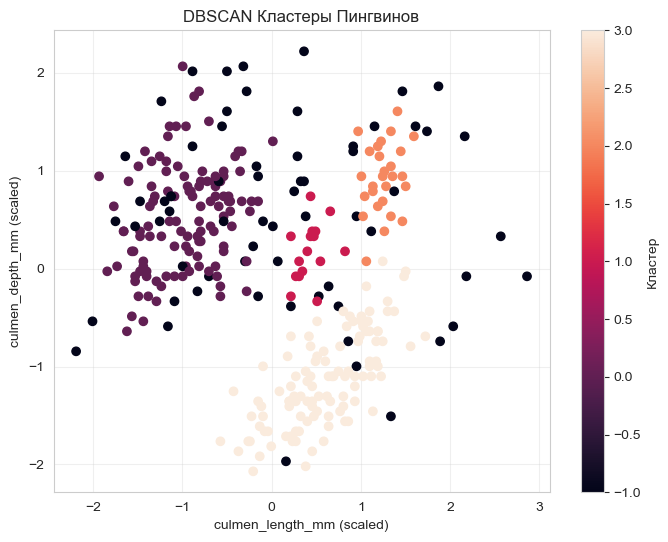

In [47]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan_labels)
plt.xlabel("culmen_length_mm (scaled)")
plt.ylabel("culmen_depth_mm (scaled)")
plt.title("DBSCAN Кластеры Пингвинов")
plt.colorbar(label='Кластер')
plt.grid(True, alpha=0.3)
plt.show()

#### Расчет метрик качества без шумовых точек (-1)

In [48]:
mask = dbscan_labels != -1

if len(np.unique(dbscan_labels[mask])) > 1:
    sil = silhouette_score(X_scaled[mask], dbscan_labels[mask])
    db = davies_bouldin_score(X_scaled[mask], dbscan_labels[mask])
    ch = calinski_harabasz_score(X_scaled[mask], dbscan_labels[mask])
    
    print(f"Silhouette Score: {sil:.4f}")
    print(f"Davies-Bouldin Score: {db:.4f}")
    print(f"Calinski-Harabasz Score: {ch:.4f}")


Silhouette Score: 0.4226
Davies-Bouldin Score: 0.7641
Calinski-Harabasz Score: 320.8401


### DBSCAN с другими параметрами

#### Создаем модель DBSCAN, но с изменёнными параметрами. Также на основе этой модели делаем обучение и предсказания. В конце заносим результаты в наш датафрейм

In [49]:
dbscan2 = DBSCAN(eps=0.8, min_samples=3)  # Изменённые параметры
dbscan_labels2 = dbscan2.fit_predict(X_scaled)
df["DBSCAN_Cluster2"] = dbscan_labels2

#### Выводим первые 10 записей обновленного датафрейма

In [50]:
df.head(10)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex,cluster,DBSCAN_Cluster,DBSCAN_Cluster2
0,39.1,18.7,181,3750,MALE,0,0,0
1,39.5,17.4,186,3800,FEMALE,0,0,0
2,40.3,18.0,195,3250,FEMALE,0,0,0
4,36.7,19.3,193,3450,FEMALE,0,0,0
5,39.3,20.6,190,3650,MALE,0,0,0
6,38.9,17.8,181,3625,FEMALE,0,0,0
7,39.2,19.6,195,4675,MALE,0,-1,0
12,41.1,17.6,182,3200,FEMALE,0,0,0
13,38.6,21.2,191,3800,MALE,0,0,0
15,36.6,17.8,185,3700,FEMALE,0,0,0


#### Выводим метки кластера

In [51]:
dbscan_labels2

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

#### Визуализация кластеров DBSCAN с изменёнными параметрами

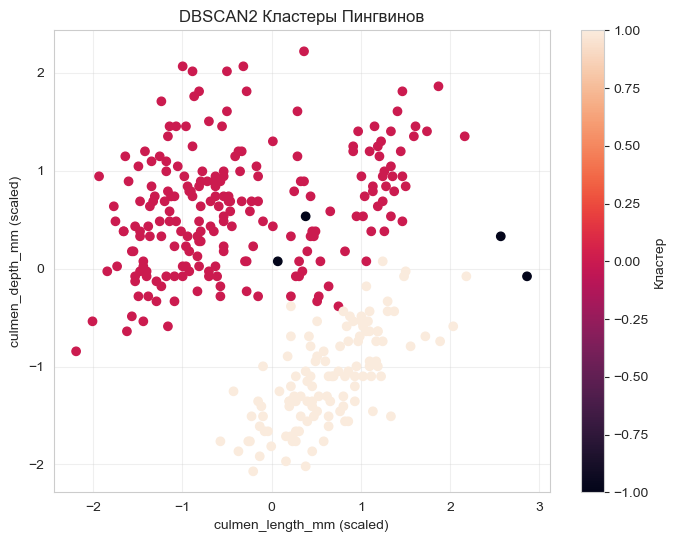

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=dbscan_labels2)
plt.xlabel("culmen_length_mm (scaled)")
plt.ylabel("culmen_depth_mm (scaled)")
plt.title("DBSCAN2 Кластеры Пингвинов")
plt.colorbar(label='Кластер')
plt.grid(True, alpha=0.3)
plt.show()

#### Расчет метрик качества без шумовых точек (-1)

In [53]:
mask2 = dbscan_labels2 != -1

if len(np.unique(dbscan_labels2[mask2])) > 1:
    sil2 = silhouette_score(X_scaled[mask2], dbscan_labels2[mask2])
    db2 = davies_bouldin_score(X_scaled[mask2], dbscan_labels2[mask2])
    ch2 = calinski_harabasz_score(X_scaled[mask2], dbscan_labels2[mask2])

    print(f"Silhouette Score: {sil2:.4f}")
    print(f"Davies-Bouldin Score: {db2:.4f}")
    print(f"Calinski-Harabasz Score: {ch2:.4f}")

Silhouette Score: 0.5349
Davies-Bouldin Score: 0.7068
Calinski-Harabasz Score: 471.4858


### Вывод различий 2 моделей DBSCAN

Вторая модель с измененными параметрами показала себя лучше по всем показателям: лучше разделяет данные по кластерам, низкое перекрытие между кластерами

## Общий вывод кластеризации

Все методы кластеризации (K-means, иерархическая и DBSCAN) успешно выявили естественные группы пингвинов. Наилучший результат показал DBSCAN с измененными параметрами, однако K-Means и иерархическая кластеризация продемонстрировали хорошие результаты, близкие к наилучшему. Все три алгоритма справились с задачей разделения пингвинов по группам.